独热编码后的列数: 78
部分列名: ['Plastic diameter(nm)', 'Concentration of plastic(μg/mL)', 'Concontration of pollutant(μg/mL)', 'Exposure time(hr)', 'Plastic type_aged-polyethylene', 'Plastic type_aged-polystyrene', 'Plastic type_other', 'Plastic type_polyethylene', 'Plastic type_polystyrene', 'Plastic surface_cooh']
X_train columns: ['Plastic diameter(nm)', 'Concentration of plastic(μg/mL)', 'Concontration of pollutant(μg/mL)', 'Exposure time(hr)', 'Plastic type_aged-polyethylene', 'Plastic type_aged-polystyrene', 'Plastic type_other', 'Plastic type_polyethylene', 'Plastic type_polystyrene', 'Plastic surface_cooh', 'Plastic surface_nh2', 'Plastic surface_none', 'Plastic shape_irregular', 'Plastic shape_microbeads', 'Plastic shape_round', 'Plastic shape_sphere', 'Pollutant type_3,6-dibromocarbazole', 'Pollutant type_acetaminophen', 'Pollutant type_ag+', 'Pollutant type_ami', 'Pollutant type_azithromycin', 'Pollutant type_b(a)p', 'Pollutant type_bde-47', 'Pollutant type_bisphenol_a', 'Pollutant typ

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names


SHAP values computed for XGB


  0%|          | 0/70 [00:00<?, ?it/s]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alp

SHAP values computed for Stacking Model (KernelExplainer)


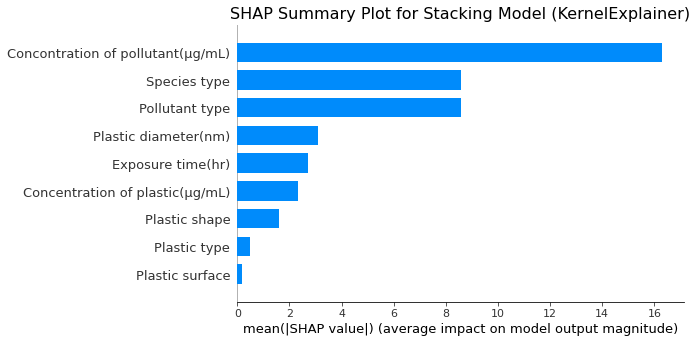

In [ ]:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os

file_path = r"d:\Desktop\1222\1225复合毒性数据.xlsx"
data = pd.read_excel(file_path).iloc[:,:-1]

target_column = 'Survival(%)'

X = data.drop(target_column, axis=1)
y = data[target_column]

X_encoded = pd.get_dummies(X)
all_columns = X_encoded.columns

print("独热编码后的列数:", X_encoded.shape[1])
print("部分列名:", X_encoded.columns.tolist()[:10])

# 划分数据集  
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=28)  
X_test = X_test.reindex(columns=all_columns, fill_value=0)

print("X_train columns:", X_train.columns.tolist())
print("X_test columns:", X_test.columns.tolist())

best_rf = RandomForestRegressor(n_estimators=85, max_depth=19, random_state=55)  
best_gb = GradientBoostingRegressor(n_estimators=199, random_state=138, max_depth=7)  
best_xgb = XGBRegressor(n_estimators=100, learning_rate=0.3, max_depth=6, random_state=60, gamma=0)  

# 定义学习器  
estimators = [  
    ('rf', best_rf),  
    ('gbdt', best_gb),  
    ('xgb', best_xgb)  
]  
 
stacking_reg = StackingRegressor(  
    estimators=estimators,  
    final_estimator=LinearRegression(),  
    cv=5  
)   
 
# 训练堆叠回归器  
stacking_reg.fit(X_train, y_train)  

# 计算每个基础模型的 SHAP 值
shap_values_list = []  

for name, estimator in estimators:  
    try:
        if isinstance(estimator, (RandomForestRegressor, GradientBoostingRegressor, XGBRegressor)):
            explainer = shap.TreeExplainer(estimator, X_train)  # 使用 TreeExplainer
            
        elif isinstance(estimator, LinearRegression):
            explainer = shap.LinearExplainer(estimator, X_train)  # 使用 LinearExplainer
        else:
            explainer = shap.Explainer(estimator, X_train)  # 使用默认解释器

        shap_values = explainer(X_train, check_additivity=False)  
        shap_values_list.append(shap_values.values)  # 保存 SHAP 值  
        print(f"SHAP values computed for {name}")
    except Exception as e:
        print(f"Error computing SHAP values for {name}: {e}")

# 计算 SHAP 值
try:
    def stacking_predict(X):
        return stacking_reg.predict(X)
    
    background = shap.sample(X_train, 100, random_state=42)   
    explainer_kernel = shap.KernelExplainer(stacking_predict, background)
    sample_X_train = X_train.sample(70, random_state=42)
    
    shap_values_stacking = explainer_kernel.shap_values(sample_X_train)
    print("SHAP values computed for Stacking Model (KernelExplainer)")
  
    # 78个特征与其所属原9个特征对应
    new_cols = []
    new_col_index = []
    for i, colName in enumerate(X_train.columns):
        ori_col = colName.split('_')[0]
        if ori_col not in new_cols:
            new_cols.append(ori_col)
            new_col_index.append([])
        new_col_index[new_cols.index(ori_col)].append(i)
    new_col_index, X_train.columns

    #shap值加和简化到原9个特征
    new_shap_values = np.zeros((shap_values_stacking.shape[0], len(new_cols)))
    for i, col_index in enumerate(new_col_index):
        new_shap_values[:,i] = shap_values_stacking[:,col_index].sum(axis=1)

    plt.figure(figsize=(10, 6)) 
    shap.summary_plot(new_shap_values, feature_names=new_cols, plot_type="bar", show=False)  
    plt.title('SHAP Summary Plot for Stacking Model (KernelExplainer)', fontsize=16)  
    plt.show()

except Exception as e:
    print(f"Error computing SHAP values for Stacking Model: {e}")